In [1]:
import pandas as pd
import numpy as np
import os
import glob
import random
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
from sklearn.metrics import mean_squared_error
import pickle

from support import *
from features.feature_ts import genX
from experiment.algorithms.cluster_prep import *
from Gauss_fit_functions import extractFIT, extractToPs , gauss, straight_line

from synthetic_profiles_functions import *

c:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\os.py
c:\Users\Jason\thesis_project


# Load Model(sample = 30) data

In [2]:
# # Load in the synthetic data
synthetic_profiles_sample_7 = pd.read_csv('CSV_Files/7/Synthetic_Profiles_sample_7.csv')
synthetic_profiles_sample_14 = pd.read_csv('CSV_Files/14/Synthetic_Profiles_sample_14.csv')
synthetic_profiles_sample_25 = pd.read_csv('CSV_Files/25/Synthetic_Profiles_sample_25.csv')
synthetic_profiles_model = pd.read_csv('CSV_Files/all/Synthetic_Profiles_sample_all.csv')

synthetic_profiles_model['date'] = pd.to_datetime(synthetic_profiles_model['date'])
synthetic_profiles_sample_14['date'] = pd.to_datetime(synthetic_profiles_sample_14['date'])
synthetic_profiles_sample_7['date'] = pd.to_datetime(synthetic_profiles_sample_7['date'])
synthetic_profiles_sample_25['date'] = pd.to_datetime(synthetic_profiles_sample_25['date'])

synthetic_profiles_sample_7.drop(['24'], axis = 1, inplace=True)

In [79]:
ids = pd.read_pickle("Ids_of_users_with_atleast_365days_of_data.pkl")

measured_profiles = pd.read_csv("Measured_Profiles_Missing_days_replaced_sorted_lenient.csv")
measured_profiles = measured_profiles[measured_profiles['ProfileID'].isin(ids)]

measured_profiles['date'] = pd.to_datetime(measured_profiles['date'])
measured_profiles['date'] = measured_profiles['date'].apply(lambda x: x.date())
# measured_profiles.set_index(['ProfileID', 'date'], inplace = True)
measured_profiles

,ProfileID,date,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
202755,695,1996-01-01,0.985750,4.109417,1.074250,1.419250,3.643583,10.296583,10.082417,9.147667,...,11.612750,8.668333,3.388667,7.225583,8.197500,5.243833,4.677750,2.391833,2.068917,1.648250
202756,695,1996-01-02,1.907667,1.904167,0.431250,0.745917,2.515500,8.386333,9.517416,14.535250,...,11.141500,14.060333,14.050333,5.163000,14.639417,11.439667,14.850416,14.425333,7.889250,1.879750
202757,695,1996-01-03,1.217000,1.090000,1.981833,3.594417,1.455667,10.883000,15.531333,14.280333,...,10.132667,7.960417,5.208333,11.852750,13.416583,5.832083,9.138500,11.399667,2.311500,2.070083
202758,695,1996-01-04,1.403833,1.487583,1.363167,2.727000,2.300917,10.251583,9.054167,6.212333,...,9.270917,10.222667,14.477667,11.548417,10.390000,10.334333,9.304167,11.652083,2.681083,2.354083
202759,695,1996-01-05,1.239750,2.198667,1.280500,2.503500,2.171000,10.705250,10.645000,7.862417,...,11.801167,20.552417,9.668500,4.797333,5.144333,6.551500,5.032500,2.160417,2.428667,2.770167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3321913,12023147,2012-12-27,3.516667,1.666667,3.666667,1.583333,1.566667,1.616667,4.233333,4.816667,...,3.466667,4.400000,5.850000,10.133333,7.733333,6.850000,8.866667,8.550000,15.316667,6.450000
3321914,12023147,2012-12-28,3.033333,1.600000,1.483333,1.533333,1.533333,1.533333,4.466667,8.133333,...,12.583333,8.133333,6.616667,5.133333,5.000000,9.983333,7.016667,14.116667,7.800000,4.283333
3321915,12023147,2012-12-29,4.016667,1.850000,1.833333,1.650000,1.700000,2.266667,1.650000,3.116667,...,5.950000,12.850000,11.833333,4.416667,10.516667,10.866667,5.250000,8.483333,9.183333,5.666667
3321916,12023147,2012-12-30,2.250000,1.700000,0.483333,0.466667,0.516667,2.000000,2.550000,1.733333,...,7.683333,10.133333,10.250000,4.916667,8.833333,7.550000,3.933333,9.450000,10.033333,5.950000


In [80]:
ids = np.intersect1d(measured_profiles.ProfileID.unique(), synthetic_profiles_sample_25.ProfileID.unique())

In [81]:
measured_profiles_df = measured_profiles[measured_profiles['ProfileID'].isin(ids)]

## Get Profiles peaks

In [4]:
def get_peaks(profiles_df):    
    # Create cols
    cols = ['ProfileID','A1','A2','mu1','mu2']

    # Create dummy variables
    mu1 = 0
    A1 = 0 
    mu2 = 0
    A2 = 0

    data=[['DROP_ROW',A1,A2,mu1,mu2]]

    amplitudes_df = pd.DataFrame(data, columns=cols)

    # profileIDs_3 = gauss_fit_features['ProfileID'].unique()

    for id in tqdm(ids):
        for index in profiles_df[profiles_df['ProfileID'] == id].index:
            A1, A2, mu1, mu2, check = extractToPs(profiles_df[profiles_df['ProfileID'] == id].loc[index])
            if check == False:
                continue
            
            data=[[id,A1,A2,mu1,mu2]]
            temp_df = pd.DataFrame(data, columns=cols)
            # temp_df.set_index(['ProfileID'])
            amplitudes_df = amplitudes_df.append(temp_df)
        
    amplitudes_df = amplitudes_df.set_index(['ProfileID'])
    temporary = amplitudes_df.copy()
    temporary.drop(['DROP_ROW'],axis = 0, inplace = True)
    # temporary.to_csv("HWeekdays_amplitudes_sample_30.csv")

    return temporary

In [73]:
Measured_peaks = get_peaks(measured_profiles_df)
Synthetic_peaks_sample_25 = get_peaks(synthetic_profiles_sample_25)
Synthetic_peaks_sample_14 = get_peaks(synthetic_profiles_sample_14)
Synthetic_peaks_sample_7 = get_peaks(synthetic_profiles_sample_7)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

# Plot Peaks Distribution Plots

In [82]:
Measured_peaks['A1']

ProfileID
695         10.835666
695         15.029833
695         15.531333
695         10.251583
695         10.705250
              ...    
12023147     9.433333
12023147     8.133333
12023147     9.083333
12023147    11.233333
12023147     7.583333
Name: A1, Length: 6944, dtype: float64

In [83]:
Synthetic_peaks_sample_7['A1']

ProfileID
695         17.436567
695         17.538574
695         17.512494
695         17.613218
695         17.500408
              ...    
12023147    15.087763
12023147    15.067489
12023147    16.995557
12023147    15.829118
12023147    15.060201
Name: A1, Length: 6951, dtype: float64

In [106]:
def plot_distribution_of_peaks(peak):    
    
  

    measured_peaks_A1 = Measured_peaks[peak]
    synthetic_peaks_A1 = Synthetic_peaks_sample_25[peak]
    measured_peaks_A2 = Measured_peaks[peak]
    synthetic_peaks_A2 = Synthetic_peaks_sample_25[peak]

    act_A1 = measured_peaks_A1
    act_A2 = measured_peaks_A2
    synth_A1 = synthetic_peaks_A1
    synth_A2 = synthetic_peaks_A2

    # Normalize
    kwargs1 = dict(alpha=0.5, bins=50, density=True, stacked=False)
    kwargs2 = dict(alpha=0.5, bins=25, density=True, stacked=False)
    # Plot
    plt.figure(figsize=(10,7), dpi= 80)
    plt.rcParams.update({'font.size': 15})
    plt.hist(act_A1, **kwargs1, color='r', label='Measured')
    plt.hist(synth_A1, **kwargs2, color='g',label='Synthetic',edgecolor=(1,0,0,1), lw=1, facecolor=(0,1,0,0.1), rwidth=0.8)

    # sns.distplot(act_A1,kde = False,hist_kws=dict(color = "white" , edgecolor="black", linewidth=2, linestyle = "--", alpha = 0.6))
    # sns.distplot(synth_A1, kde = False, hist_kws=dict(color = "red"))

    # sns.distplot(act_A2,kde = False,hist_kws=dict(color = "white" , edgecolor="black", linewidth=2, linestyle = "--", alpha = 0.6))
    # sns.distplot(synth_A2, kde = False, hist_kws=dict(color = "blue"))
    
    plt.title('Distribution Plot of ' + peak +' peaks', fontsize = 15)
    plt.ylabel('Probability', fontsize = 15)
    plt.xlabel('Consumption [Ah]', fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.legend(labels = ["Measured " + peak,"Synthetic " + peak],fontsize = 15)#,"Measured A2","Synthetic A2"

    plt.xlim(0,50)

    # plt.savefig(peak+"_peaks_sample_7_" + str(id) + ".png")
    # plt.legend();

In [107]:
# def plot_distribution_of_peaks(peak):    
    
#     for id in ids:
#         try:    
#             measured_peaks_A1 = Measured_peaks.loc[id][peak]
#             synthetic_peaks_A1 = Synthetic_peaks_sample_25.loc[id][peak]
#             measured_peaks_A2 = Measured_peaks.loc[id][peak]
#             synthetic_peaks_A2 = Synthetic_peaks_sample_25.loc[id][peak]

#             act_A1 = measured_peaks_A1
#             act_A2 = measured_peaks_A2
#             synth_A1 = synthetic_peaks_A1
#             synth_A2 = synthetic_peaks_A2

#             # Normalize
#             kwargs = dict(alpha=0.5, bins=10, density=True, stacked=True)

#             # Plot
#             plt.figure(figsize=(10,7), dpi= 80)
#             plt.rcParams.update({'font.size': 15})
#             plt.hist(act_A1, **kwargs, color='r', label='Measured')
#             plt.hist(synth_A1, **kwargs, color='g',label='Synthetic',edgecolor=(1,0,0,1), lw=1, facecolor=(0,1,0,0.1), rwidth=0.8)

#             # sns.distplot(act_A1,kde = False,hist_kws=dict(color = "white" , edgecolor="black", linewidth=2, linestyle = "--", alpha = 0.6))
#             # sns.distplot(synth_A1, kde = False, hist_kws=dict(color = "red"))

#             # sns.distplot(act_A2,kde = False,hist_kws=dict(color = "white" , edgecolor="black", linewidth=2, linestyle = "--", alpha = 0.6))
#             # sns.distplot(synth_A2, kde = False, hist_kws=dict(color = "blue"))
            
#             plt.title('Distribution Plot of ' + peak +' peaks', fontsize = 15)
#             plt.ylabel('Probability', fontsize = 15)
#             plt.xlabel('Consumption [Ah]', fontsize = 15)
#             plt.xticks(fontsize = 15)
#             plt.yticks(fontsize = 15)
#             plt.legend(title = "Household " + str(id), labels = ["Measured " + peak,"Synthetic " + peak],fontsize = 15)#,"Measured A2","Synthetic A2"

#             # plt.xlim(0,35)
#         except KeyError:
#             continue
#         # plt.savefig(peak+"_peaks_sample_7_" + str(id) + ".png")
#         # plt.legend();

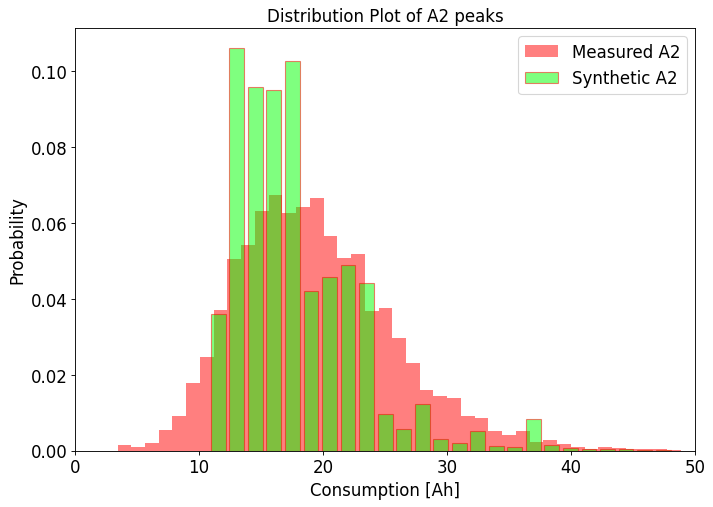

In [108]:
plot_distribution_of_peaks("A2")

In [143]:
Measured_daily['Daily'] = measured_profiles_df.set_index(['ProfileID', 'date']).sum(axis = 1).to_frame()
Measured_daily
Synthetic_daily_sample_25['Daily'] = synthetic_profiles_sample_25.set_index(['ProfileID', 'date']).sum(axis = 1).to_frame()
Synthetic_daily_sample_14['Daily'] = synthetic_profiles_sample_14.set_index(['ProfileID', 'date']).sum(axis = 1).to_frame()
Synthetic_daily_sample_7['Daily'] = synthetic_profiles_sample_7.set_index(['ProfileID', 'date']).sum(axis = 1).to_frame()

Synthetic_daily_sample_7

0         Daily
ProfileID date                                  
695       1996-01-01    300.847595    300.847595
          1996-01-02    253.032683    253.032683
          1996-01-03    268.513021    268.513021
          1996-01-04    284.300137    284.300137
          1996-01-05   5198.709018   5198.709018
...                            ...           ...
12023147  2012-12-27  10120.874222  10120.874222
          2012-12-28   9896.498939   9896.498939
          2012-12-29    237.696562    237.696562
          2012-12-30    229.927320    229.927320
          2012-12-31  10103.851084  10103.851084

[6951 rows x 2 columns]

In [180]:
def plot_distribution_of_daily(synthetic_1, synthetic_2, synthetic_3):      
  
    measured_daily = Measured_daily['Daily'].values
    synthetic_daily_1 = synthetic_1['Daily'].values
    synthetic_daily_2 = synthetic_2['Daily'].values
    synthetic_daily_3 = synthetic_3['Daily'].values
    # measured_peaks_A2 = Measured_peaks[0]
    # synthetic_peaks_A2 = Synthetic_peaks_sample_25[0]

    # act_A1 = measured_peaks_A1
    # act_A2 = measured_peaks_A2
    # synth_A1 = synthetic_peaks_A1
    # synth_A2 = synthetic_peaks_A2

    # Normalize
    kwargs = dict(alpha=0.5, bins=50, density=True, stacked=False)
    kwargs1 = dict(alpha=0.5, bins=200, density=True, stacked=False)
    kwargs2 = dict(alpha=0.5, bins=400, density=True, stacked=False)
    kwargs3 = dict(alpha=0.5, bins=400, density=True, stacked=False)

    # Plot
    plt.figure(figsize=(10,7), dpi= 80)
    plt.rcParams.update({'font.size': 15})
    plt.hist(measured_daily, **kwargs, color='r', label='Measured')


    plt.hist(synthetic_daily_3, **kwargs3, color='blue',label='Synthetic', rwidth=0.8)
    plt.hist(synthetic_daily_2, **kwargs2, color='yellow',label='Synthetic', rwidth=0.8)
    plt.hist(synthetic_daily_1, **kwargs1, color='g',label='Synthetic', rwidth=0.8)
    # sns.distplot(act_A1,kde = False,hist_kws=dict(color = "white" , edgecolor="black", linewidth=2, linestyle = "--", alpha = 0.6))
    # sns.distplot(synth_A1, kde = False, hist_kws=dict(color = "red"))

    # sns.distplot(act_A2,kde = False,hist_kws=dict(color = "white" , edgecolor="black", linewidth=2, linestyle = "--", alpha = 0.6))
    # sns.distplot(synth_A2, kde = False, hist_kws=dict(color = "blue"))
    
    plt.title('Distribution Plot of Daily Consumption', fontsize = 15)
    plt.ylabel('Probability', fontsize = 15)
    plt.xlabel('Consumption [Ah]', fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.legend(labels = ["Measured ","Synthetic (Sample = 25)","Synthetic (Sample = 14)","Synthetic (Sample =7)"],fontsize = 15)#,"Measured A2","Synthetic A2"

    plt.xlim(0,1000)

    # plt.savefig(peak+"_peaks_sample_7_" + str(id) + ".png")
    # plt.legend();

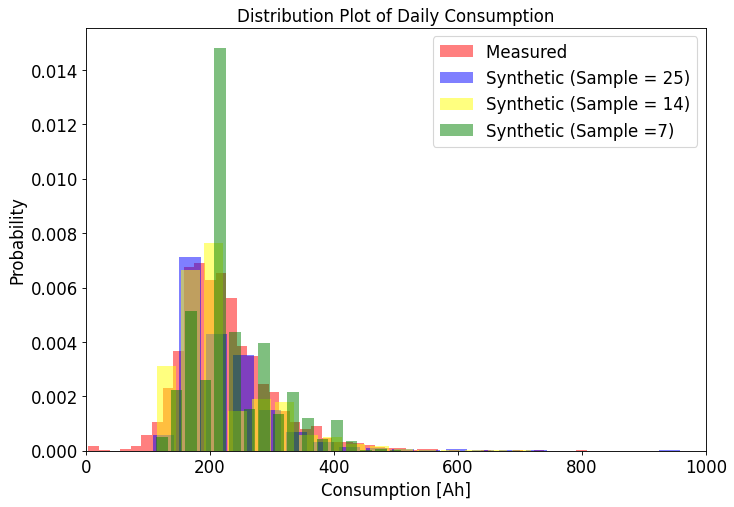

In [181]:
plot_distribution_of_daily(Synthetic_daily_sample_25, Synthetic_daily_sample_14,Synthetic_daily_sample_7)

# Boxplot of daily distributions

In [33]:
# # Percentiles A1
# act_A1_25th = Measured_peaks.describe().loc['25%']['A1']
# act_A1_50th = Measured_peaks.describe().loc['50%']['A1']
# act_A1_75th = Measured_peaks.describe().loc['75%']['A1']

# synth_A1_25th = Synthetic_peaks.describe().loc['25%']['A1']
# synth_A1_50th = Synthetic_peaks.describe().loc['50%']['A1']
# synth_A1_75th = Synthetic_peaks.describe().loc['75%']['A1']

# # Percentiles A2
# act_A2_25th = Measured_peaks.describe().loc['25%']['A2']
# act_A2_50th = Measured_peaks.describe().loc['50%']['A2']
# act_A2_75th = Measured_peaks.describe().loc['75%']['A2']

# synth_A2_25th = Synthetic_peaks.describe().loc['25%']['A2']
# synth_A2_50th = Synthetic_peaks.describe().loc['50%']['A2']
# synth_A2_75th = Synthetic_peaks.describe().loc['75%']['A2']

# # Percentage Error A1
# A1_25_RMSE = np.abs(act_A1_25th - synth_A1_25th)/act_A1_25th*100
# A1_50_RMSE = np.abs(act_A1_50th - synth_A1_50th)/act_A1_50th*100
# A1_75_RMSE = np.abs(act_A1_75th - synth_A1_75th)/act_A1_75th*100

# # Percentage Error A2
# A2_25_RMSE = np.abs(act_A2_25th - synth_A2_25th)/act_A2_25th*100
# A2_50_RMSE = np.abs(act_A2_50th - synth_A2_50th)/act_A2_50th*100
# A2_75_RMSE = np.abs(act_A2_75th - synth_A2_75th)/act_A2_75th*100

In [71]:
    
for id in ids:    
    
    # Percentiles A1
    act_A1_25th = Measured_peaks.loc[id].describe().loc['25%']['A1']
    act_A1_50th = Measured_peaks.loc[id].describe().loc['50%']['A1']
    act_A1_75th = Measured_peaks.loc[id].describe().loc['75%']['A1']

    synth_A1_25th = Synthetic_peaks.loc[id].describe().loc['25%']['A1']
    synth_A1_50th = Synthetic_peaks.loc[id].describe().loc['50%']['A1']
    synth_A1_75th = Synthetic_peaks.loc[id].describe().loc['75%']['A1']

    # Percentiles A2
    act_A2_25th = Measured_peaks.loc[id].describe().loc['25%']['A2']
    act_A2_50th = Measured_peaks.loc[id].describe().loc['50%']['A2']
    act_A2_75th = Measured_peaks.loc[id].describe().loc['75%']['A2']

    synth_A2_25th = Synthetic_peaks.loc[id].describe().loc['25%']['A2']
    synth_A2_50th = Synthetic_peaks.loc[id].describe().loc['50%']['A2']
    synth_A2_75th = Synthetic_peaks.loc[id].describe().loc['75%']['A2']

    # Percentage Error A1
    A1_25_RMSE = np.abs(act_A1_25th - synth_A1_25th)/act_A1_25th*100
    A1_50_RMSE = np.abs(act_A1_50th - synth_A1_50th)/act_A1_50th*100
    A1_75_RMSE = np.abs(act_A1_75th - synth_A1_75th)/act_A1_75th*100

    # Percentage Error A2
    A2_25_RMSE = np.abs(act_A2_25th - synth_A2_25th)/act_A2_25th*100
    A2_50_RMSE = np.abs(act_A2_50th - synth_A2_50th)/act_A2_50th*100
    A2_75_RMSE = np.abs(act_A2_75th - synth_A2_75th)/act_A2_75th*100
        
    measured_peaks_A1 = Measured_peaks.loc[id]['A1']
    synthetic_peaks_A1 = Measured_peaks.loc[id]['A1']
    measured_peaks_A2 = Measured_peaks.loc[id]['A2']
    synthetic_peaks_A2 = Measured_peaks.loc[id]['A2']

    data_to_plot = [measured_peaks_A1,synthetic_peaks_A1,measured_peaks_A2,synthetic_peaks_A2]
    # sns.set(font_scale=2)
    ax = sns.boxplot(data=data_to_plot, showfliers = False)


    q1_A1 = synthetic_peaks_A1.quantile(0.25) + 0.45
    q2_A1 = synthetic_peaks_A1.quantile(0.5) + 0.45
    q3_A1 = synthetic_peaks_A1.quantile(0.75) + 0.45

    q1_A2 = synthetic_peaks_A2.quantile(0.25) + 0.45
    q2_A2 = synthetic_peaks_A2.quantile(0.5) + 0.45
    q3_A2 = synthetic_peaks_A2.quantile(0.75) + 0.45

    # # Box 1
    # # 25th Percentile
    # plt.text(0.75, q1_A1,
    #         'Q1 = ' + str('{0:.2g}').format(A1_25_RMSE) + '%',
    #         bbox=dict(facecolor='red',
    #                 alpha=0.5),
    #         fontsize='medium')

    # # 50th Percentile
    # plt.text(0.75, q2_A1,
    #         'Q2 = ' + str('{0:.2g}').format(A1_50_RMSE) + '%',
    #         bbox=dict(facecolor='red',
    #                 alpha=0.5),
    #         fontsize='medium')

    # # 75th Percentile
    # plt.text(0.75, q3_A1,
    #         'Q3 = ' + str('{0:.2g}').format(A1_75_RMSE) + '%',
    #         bbox=dict(facecolor='red',
    #                 alpha=0.5),
    #         fontsize='medium')

    # # Box 3
    # # 25th Percentile
    # plt.text(2.75, q1_A2,
    #         'Q1 = ' + str('{0:.3g}').format(A2_25_RMSE) + '%',
    #         bbox=dict(facecolor='red',
    #                 alpha=0.5),
    #         fontsize='medium')

    # # 50th Percentile
    # plt.text(2.75, q2_A2,
    #         'Q2 = ' + str('{0:.2g}').format(A2_50_RMSE) + '%',
    #         bbox=dict(facecolor='red',
    #                 alpha=0.5),
    #         fontsize='medium')

    # # 75th Percentile
    # plt.text(2.75, q3_A2,
    #         'Q3 = ' + str('{0:.2g}').format(A2_75_RMSE) + '%',
    #         bbox=dict(facecolor='red',
    #         alpha=0.5),
    #         fontsize='medium')



    # plt.text(95,1,
    #         'Points beyond beyond 75% value',
    #         bbox=dict(facecolor='pink',
    #                 alpha=0.5),
    #         horizontalalignment='right',
    #         fontsize='small')

    sns.set(rc={"figure.figsize":(10, 11)}) #width=3, #height=4

    plt.title("Boxplot of Model(sample = 7)\n Synthetic vs. Actual Peaks",fontsize = 20)
    plt.ylabel('Consumption [Ah]',fontsize = 15)
    # plt.xlabel('Household ' + str(id),fontsize = 15)
    plt.xticks([0,1,2,3],['Measured A1', 'Synthetic A1','Measured A2', 'Synthetic A2'],fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.legend(title='Household ' + str(id), loc='upper left', fontsize = 15)
    plt.rcParams.update({'font.size': 15})
    plt.ylim([0,30])
    fig = ax.get_figure()
    fig.savefig("Boxplot_daily_sample_7_" + str(id) + ".png")
    fig.clear(True)
    # plt.legend(labels = ['Synthetic A1', 'Measured A1','Synthetic A2', 'Measured A2'], fontsize = 'medium')


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

# Daily Mean Profiles

### Get the mean profiles for each season
### Calculate the error between the mean profiles for the measured and synthetic profiles

In [3]:
measured_profiles["date"] = pd.to_datetime(measured_profiles["date"])
# synthetic_profiles["date"] = pd.to_datetime(synthetic_profiles["date"])

In [7]:
def split_into_seasons(df):
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday']
    weekends = ['Sunday', 'Saturday']

    df['month'] = df.date.dt.month
    df['season'] = df['month'].apply(lambda x: 'HIGH' if x in [6, 7, 8] else 'LOW') 
    df['day_names'] = df.date.dt.day_name()
    df['daytype'] = df['day_names'].apply(lambda x: 'WEEKDAY' if x in weekdays else 'WEEKEND')

    # Split into season
    df_low_season = df[df['season'] == 'LOW'] # Create dataframe with all the winter months, excluding weekends
    df_high_season = df[df['season'] == 'HIGH']

    # Split into daytypes
    HWeekdays = df_high_season[df_high_season['daytype'] == 'WEEKDAY'] # Create dataframe with only weekdays
    HWeekends = df_high_season[df_high_season['daytype'] == 'WEEKEND'] 
    LWeekdays = df_low_season[df_low_season['daytype'] == 'WEEKDAY'] 
    LWeekends = df_low_season[df_low_season['daytype'] == 'WEEKEND'] 

    HWeekdays.drop(['month','season','day_names','daytype'], axis = 1, inplace = True)
    HWeekends.drop(['month','season','day_names','daytype'], axis = 1, inplace = True)
    LWeekdays.drop(['month','season','day_names','daytype'], axis = 1, inplace = True)
    LWeekends.drop(['month','season','day_names','daytype'], axis = 1, inplace = True)

    return HWeekdays, HWeekends, LWeekdays, LWeekends

In [8]:
HWeekdays_measured, HWeekends_measured, LWeekdays_measured, LWeekends_measured = split_into_seasons(measured_profiles)
# HWeekdays_synthetic_sample_30, HWeekends_synthetic_sample_30, LWeekdays_synthetic_sample_30, LWeekends_synthetic_sample_30 = split_into_seasons(synthetic_profiles)

### Plot the seasonal daily mean profiles

In [75]:
def plot_mean_daily_profiles(season):

    if season == "HWeekday":
        text = "High Season Weekdays"
        season_measured_mean = HWeekdays_measured.groupby(['ProfileID']).mean()
        season_synthetic_mean = HWeekdays_synthetic_sample_7.groupby(['ProfileID']).mean()
    elif season == "HWeekend":
        text = "High Season Weekends"
        season_measured_mean = HWeekends_measured.groupby(['ProfileID']).mean()
        season_synthetic_mean = HWeekends_synthetic_sample_7.groupby(['ProfileID']).mean()

    elif season == "LWeekday":
        text = "Low Season Weekdays"
        season_measured_mean = LWeekdays_measured.groupby(['ProfileID']).mean()
        season_synthetic_mean = LWeekdays_synthetic_sample_7.groupby(['ProfileID']).mean()

    elif season == "LWeekend":
        text = "Low Season Weekends"
        season_measured_mean = LWeekends_measured.groupby(['ProfileID']).mean()
        season_synthetic_mean = LWeekends_synthetic_sample_7.groupby(['ProfileID']).mean()


    for id in ids:


        # build the plot
        fig, ax = plt.subplots(figsize=(12,6))
        plt.style.use('fivethirtyeight')  

        # Plot the households loadprofile
        fig = plt.plot(season_synthetic_mean.loc[id], linewidth = 2, label = "Synthetic Profile")#, linestyle = 'dashed')
        plt.title("Mean Daily Profile, " + text)

        ax.plot(season_measured_mean.loc[id], linewidth = 2, label = "Measured Profile", color = 'purple')

        ax.set_facecolor("white")
        x_all = np.arange(0,24,1)
        plt.legend(title = "Household " + str(id),loc = "upper left", facecolor = "white")

        # Set the labels and axis limits
        ax.set_xlim([0,24])
        ax.set_xlabel('Time of day')
        ax.set_ylabel("Current [Ah]")
        # ax.set_title('Meter Number: ' + str(houseID))

        # # Save the figure
        plt.savefig('Mean_daily_profile_sample_7_' + season + '_household_' + str(id) + '.png', dpi=72, bbox_inches='tight',facecolor='white', edgecolor='none')
        plt.show()

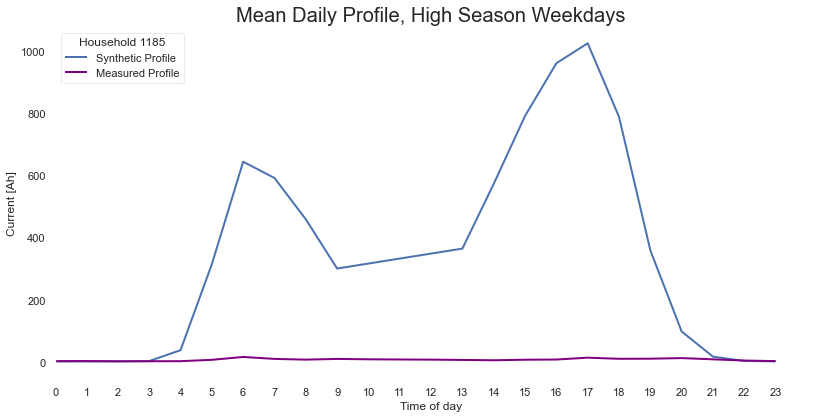

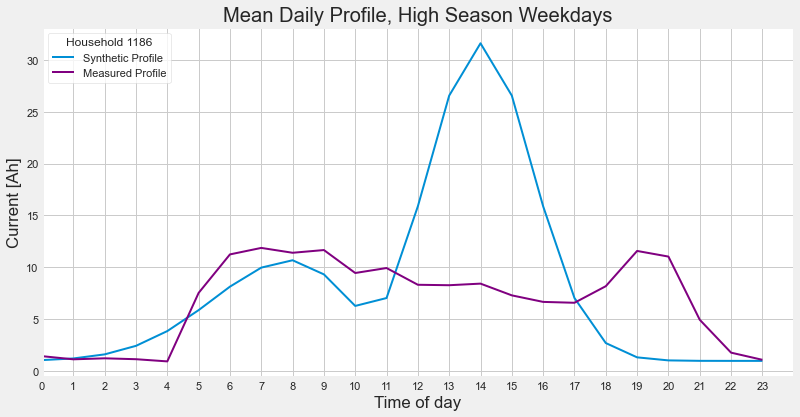

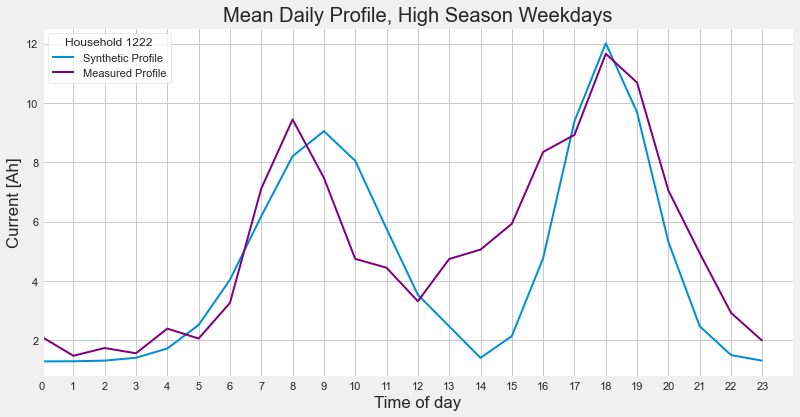

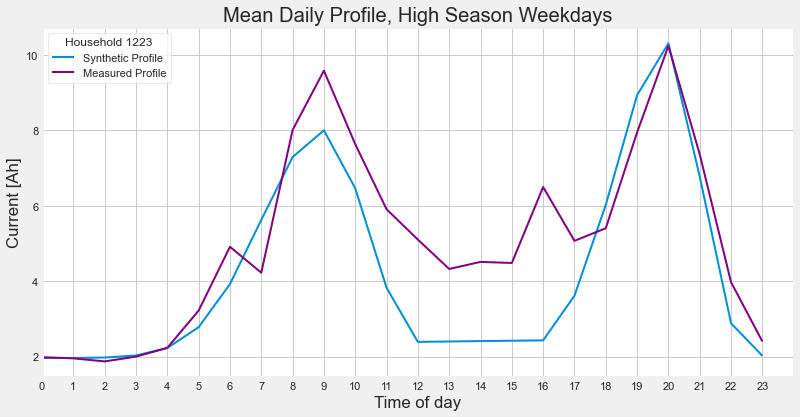

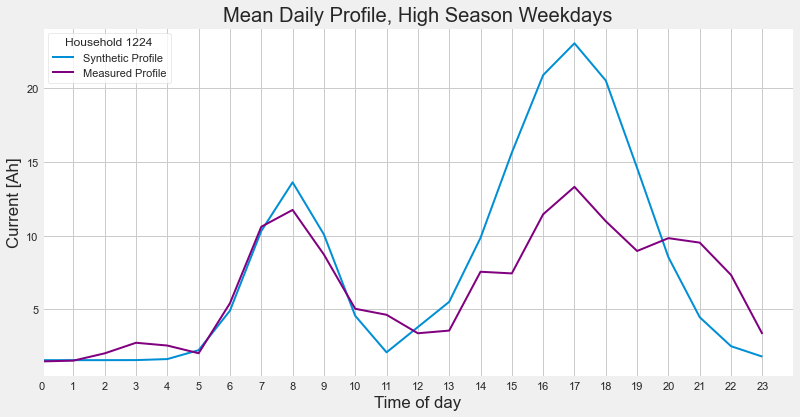

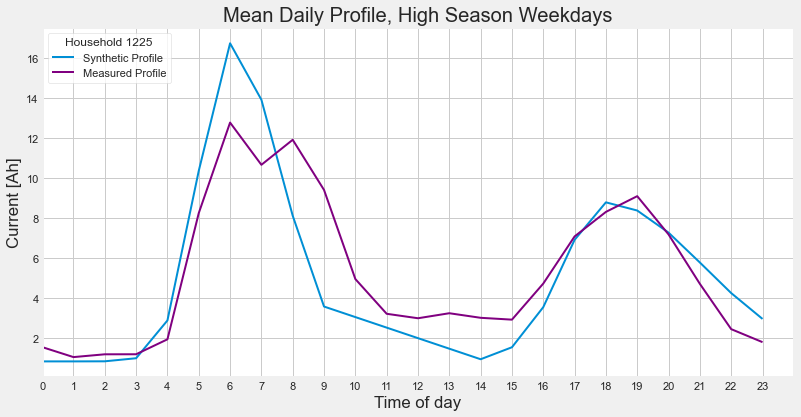

In [76]:
plot_mean_daily_profiles("HWeekday")

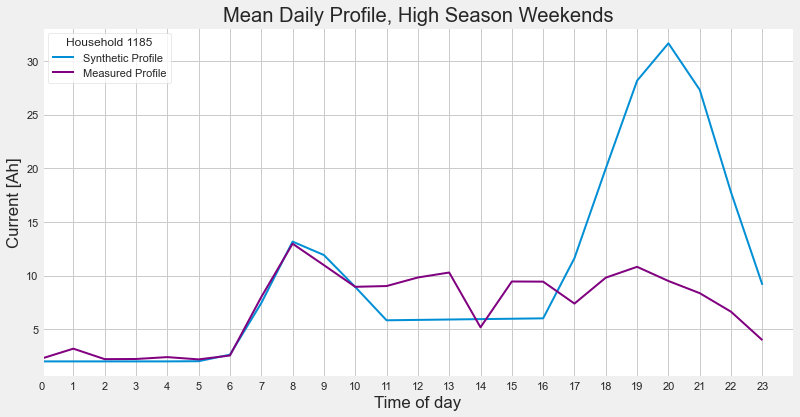

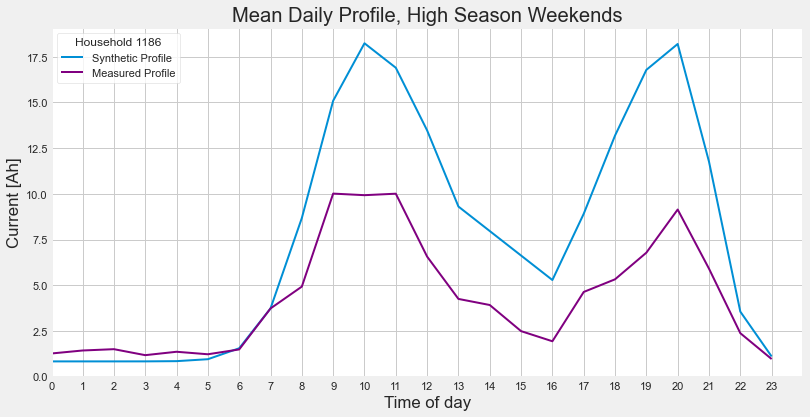

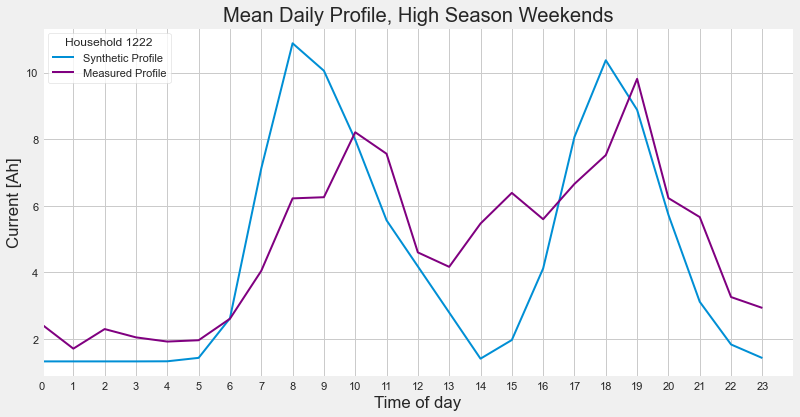

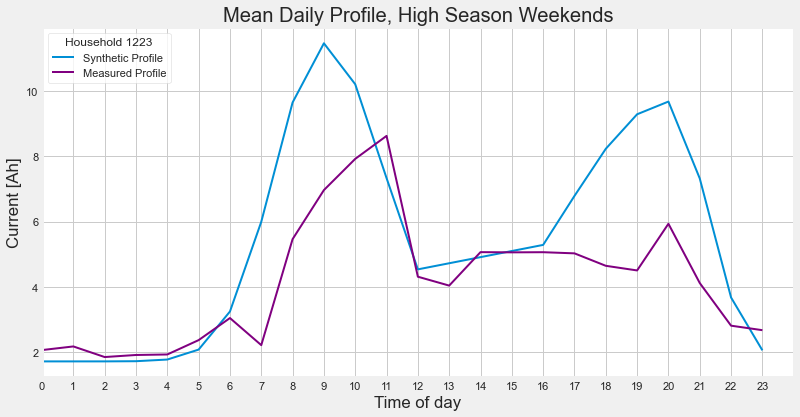

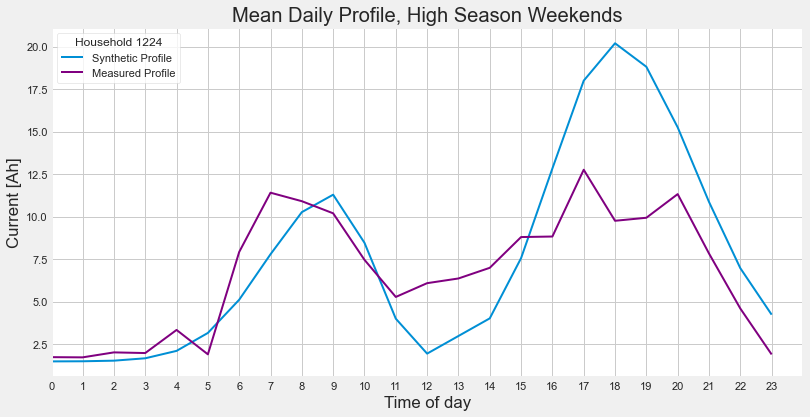

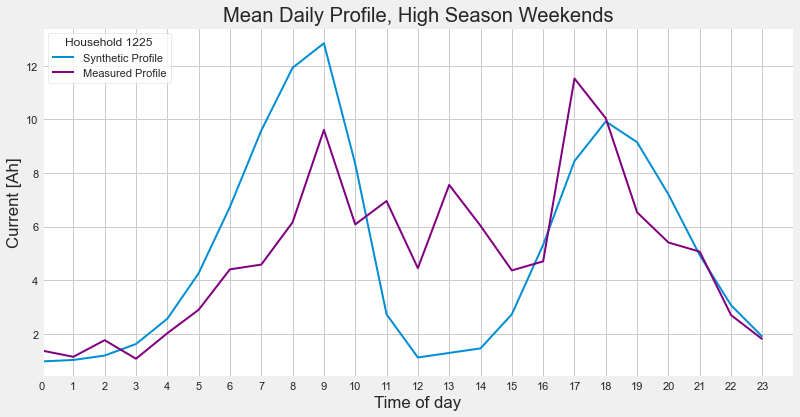

In [77]:
plot_mean_daily_profiles("HWeekend")

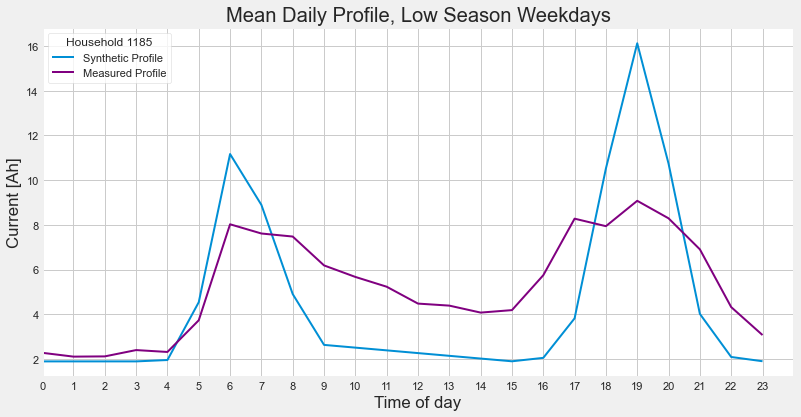

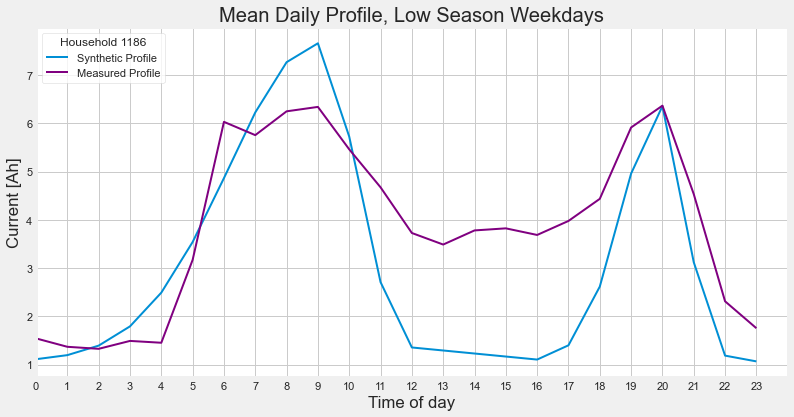

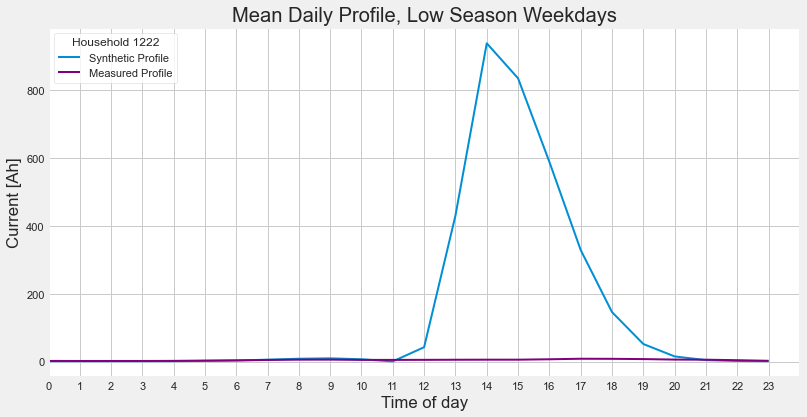

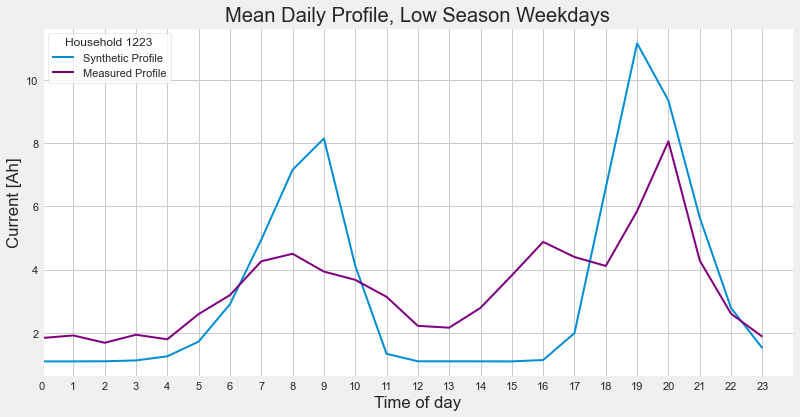

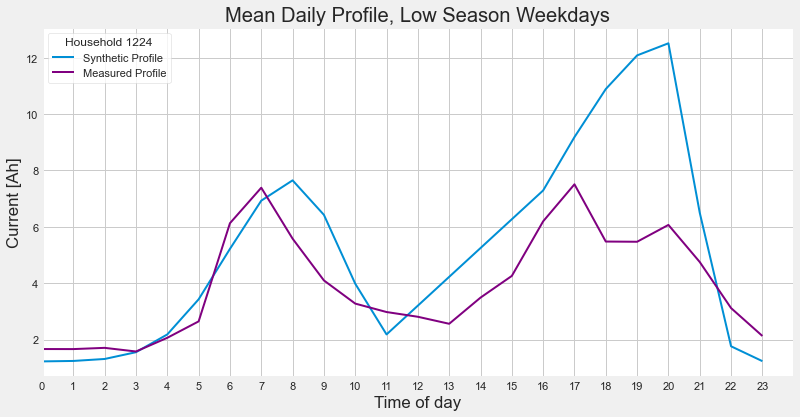

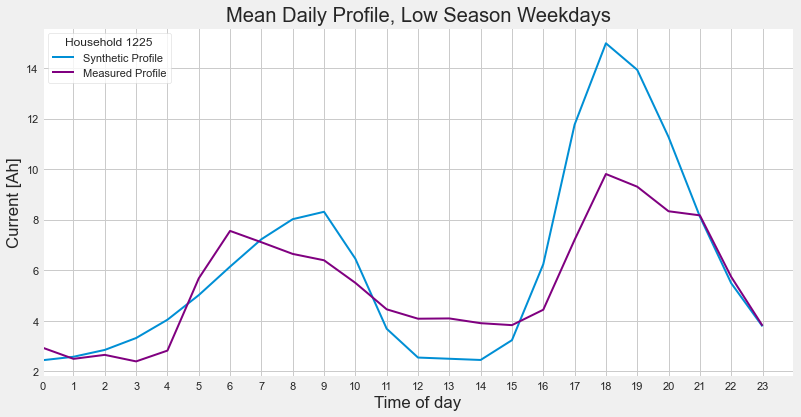

In [78]:
plot_mean_daily_profiles("LWeekday")

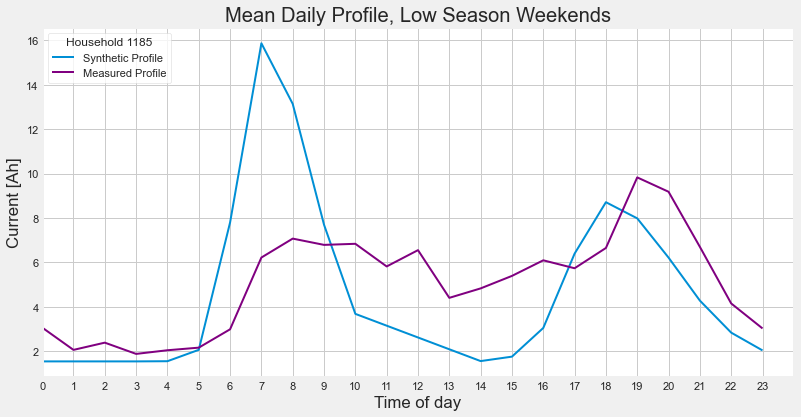

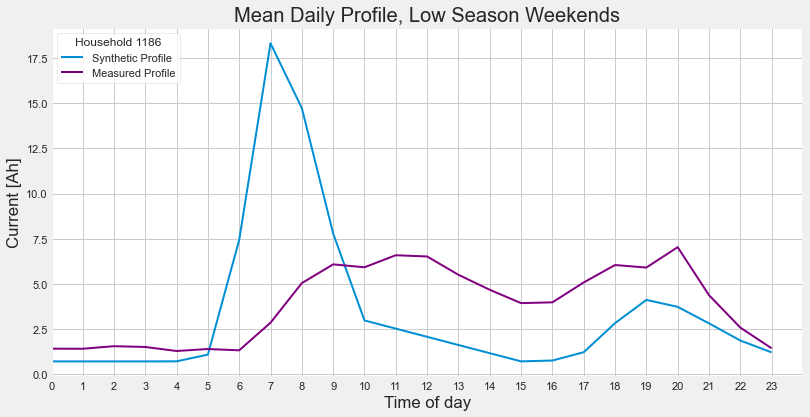

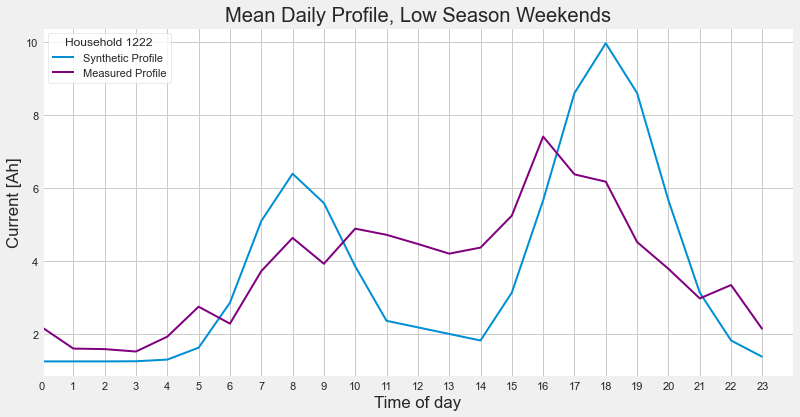

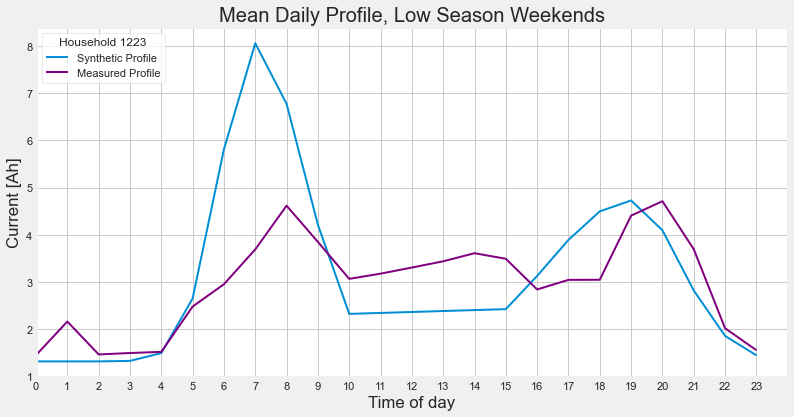

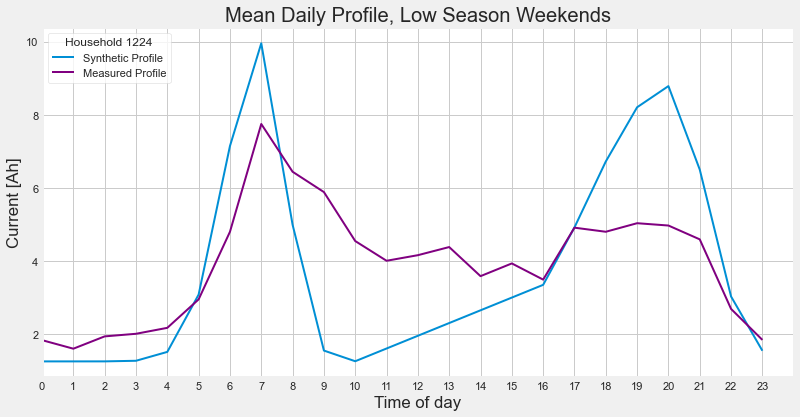

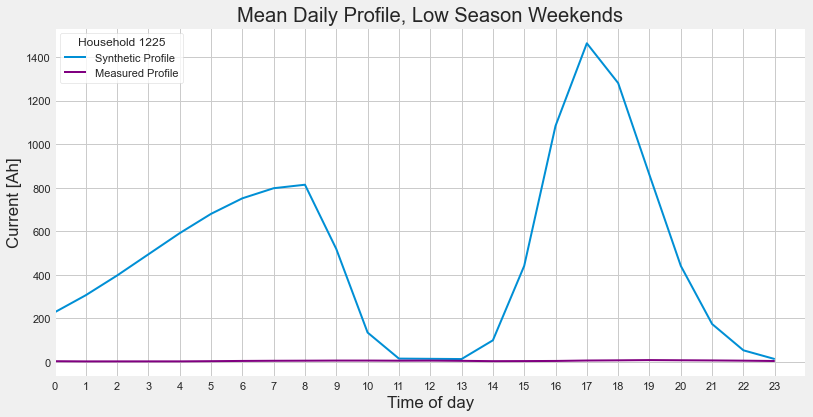

In [79]:
plot_mean_daily_profiles("LWeekend")

# Calculate the error between the measured mean profiles and the two models

In [51]:
# # Load in the synthetic data
synthetic_profiles_sample_7 = pd.read_csv('CSV_Files/7/Synthetic_Profiles_sample_7.csv')
synthetic_profiles_sample_14 = pd.read_csv('CSV_Files/14/Synthetic_Profiles_sample_14.csv')
synthetic_profiles_sample_25 = pd.read_csv('CSV_Files/25/Synthetic_Profiles_sample_25.csv')
synthetic_profiles_model = pd.read_csv('CSV_Files/all/Synthetic_Profiles_sample_all.csv')

synthetic_profiles_model['date'] = pd.to_datetime(synthetic_profiles_model['date'])
synthetic_profiles_sample_14['date'] = pd.to_datetime(synthetic_profiles_sample_14['date'])
synthetic_profiles_sample_7['date'] = pd.to_datetime(synthetic_profiles_sample_7['date'])
synthetic_profiles_sample_25['date'] = pd.to_datetime(synthetic_profiles_sample_25['date'])

synthetic_profiles_sample_7.drop(['24'], axis = 1, inplace=True)


In [52]:
synthetic_profiles_sample_7.columns

Index(['ProfileID', 'date', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23', '24'],
      dtype='object')

In [53]:
# synthetic_profiles_model.drop(['month','season','day_names','daytype'], axis = 1, inplace=True)
# synthetic_profiles_sample_14.drop(['month','season','day_names','daytype'], axis = 1, inplace=True)
synthetic_profiles_sample_7.drop(['24'], axis = 1, inplace=True)



In [54]:
HWeekdays_synthetic_model, HWeekends_synthetic_model, LWeekdays_synthetic_model, LWeekends_synthetic_model = split_into_seasons(synthetic_profiles_model)
# HWeekdays_synthetic_sample_30, HWeekends_synthetic_sample_30, LWeekdays_synthetic_sample_30, LWeekends_synthetic_sample_30 = split_into_seasons(synthetic_profiles_sample_30)
HWeekdays_synthetic_sample_7, HWeekends_synthetic_sample_7, LWeekdays_synthetic_sample_7, LWeekends_synthetic_sample_7 = split_into_seasons(synthetic_profiles_sample_7)
HWeekdays_synthetic_sample_14, HWeekends_synthetic_sample_14, LWeekdays_synthetic_sample_14, LWeekends_synthetic_sample_14 = split_into_seasons(synthetic_profiles_sample_14)
HWeekdays_synthetic_sample_25, HWeekends_synthetic_sample_25, LWeekdays_synthetic_sample_25, LWeekends_synthetic_sample_25 = split_into_seasons(synthetic_profiles_sample_25)

In [55]:
# Measured data mean profiles
LWeekends_measured_mean = LWeekends_measured.groupby(['ProfileID']).mean()
HWeekdays_measured_mean = HWeekdays_measured.groupby(['ProfileID']).mean()
LWeekdays_measured_mean = LWeekdays_measured.groupby(['ProfileID']).mean()
HWeekends_measured_mean = HWeekends_measured.groupby(['ProfileID']).mean()

# Model (sample = 7) mean profiles
LWeekends_sample_7_mean = LWeekends_synthetic_sample_7.groupby(['ProfileID']).mean()
LWeekdays_sample_7_mean = LWeekdays_synthetic_sample_7.groupby(['ProfileID']).mean()
HWeekends_sample_7_mean = HWeekends_synthetic_sample_7.groupby(['ProfileID']).mean()
HWeekdays_sample_7_mean = HWeekdays_synthetic_sample_7.groupby(['ProfileID']).mean()

# Model (sample = 14) mean profiles
LWeekends_sample_14_mean = LWeekends_synthetic_sample_14.groupby(['ProfileID']).mean()
LWeekdays_sample_14_mean = LWeekdays_synthetic_sample_14.groupby(['ProfileID']).mean()
HWeekends_sample_14_mean = HWeekends_synthetic_sample_14.groupby(['ProfileID']).mean()
HWeekdays_sample_14_mean = HWeekdays_synthetic_sample_14.groupby(['ProfileID']).mean()

# Model (sample = 30) mean profiles
LWeekends_sample_25_mean = LWeekends_synthetic_sample_25.groupby(['ProfileID']).mean()
LWeekdays_sample_25_mean = LWeekdays_synthetic_sample_25.groupby(['ProfileID']).mean()
HWeekends_sample_25_mean = HWeekends_synthetic_sample_25.groupby(['ProfileID']).mean()
HWeekdays_sample_25_mean = HWeekdays_synthetic_sample_25.groupby(['ProfileID']).mean()


# # Model (sample = 30) mean profiles
# LWeekends_sample_mean = LWeekends_synthetic_sample_30.groupby(['ProfileID']).mean()
# LWeekdays_sample_mean = LWeekdays_synthetic_sample_30.groupby(['ProfileID']).mean()
# HWeekends_sample_mean = HWeekends_synthetic_sample_30.groupby(['ProfileID']).mean()
# HWeekdays_sample_mean = HWeekdays_synthetic_sample_30.groupby(['ProfileID']).mean()

# Model (all data) mean profiles
HWeekdays_model_mean = HWeekdays_synthetic_model.groupby(['ProfileID']).mean() 
HWeekends_model_mean = HWeekends_synthetic_model.groupby(['ProfileID']).mean()
LWeekdays_model_mean = HWeekdays_synthetic_model.groupby(['ProfileID']).mean()
LWeekends_model_mean = LWeekends_synthetic_model.groupby(['ProfileID']).mean()

In [56]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

def rmse(actual, predicted):
    MSE = mean_squared_error(actual, predicted)
    RMSE = math.sqrt(MSE)
    return RMSE

In [81]:
def calculate_error_mean_profiles(actual_df, predicted_all_df,predicted_sample_25_df, predicted_sample_14_df,predicted_sample_7_df):

    mape_data = {"Household":[ids[0],ids[1],ids[2],ids[3],ids[4],ids[5],ids[6],ids[7],ids[8],ids[9],ids[10],ids[11],ids[12],ids[13],ids[14],ids[15],ids[16],ids[17],ids[18],ids[19],ids[20],ids[21],ids[22],ids[23],ids[24]], "Metric":["MAPE","MAPE","MAPE","MAPE","MAPE","MAPE","MAPE","MAPE","MAPE","MAPE","MAPE","MAPE","MAPE","MAPE","MAPE","MAPE","MAPE","MAPE","MAPE","MAPE","MAPE","MAPE","MAPE","MAPE","MAPE"],
                 "Model(Sample = all)":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], "Model(Sample = 25)":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                 "Model(Sample = 14)":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],"Model(Sample = 7)":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]}
    smape_data = {"Household":[ids[0],ids[1],ids[2],ids[3],ids[4],ids[5],ids[6],ids[7],ids[8],ids[9],ids[10],ids[11],ids[12],ids[13],ids[14],ids[15],ids[16],ids[17],ids[18],ids[19],ids[20],ids[21],ids[22],ids[23],ids[24]], "Metric":["sMAPE","sMAPE","sMAPE","sMAPE","sMAPE","sMAPE","sMAPE","sMAPE","sMAPE","sMAPE","sMAPE","sMAPE","sMAPE","sMAPE","sMAPE","sMAPE","sMAPE","sMAPE","sMAPE","sMAPE","sMAPE","sMAPE","sMAPE","sMAPE","sMAPE"],
                "Model(Sample = all)":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],"Model(Sample = 25)":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                "Model(Sample = 14)":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],"Model(Sample = 7)":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]}
    rmse_data = {"Household":[ids[0],ids[1],ids[2],ids[3],ids[4],ids[5],ids[6],ids[7],ids[8],ids[9],ids[10],ids[11],ids[12],ids[13],ids[14],ids[15],ids[16],ids[17],ids[18],ids[19],ids[20],ids[21],ids[22],ids[23],ids[24]], "Metric":["RMSE","RMSE","RMSE","RMSE","RMSE","RMSE","RMSE","RMSE","RMSE","RMSE","RMSE","RMSE","RMSE","RMSE","RMSE","RMSE","RMSE","RMSE","RMSE","RMSE","RMSE","RMSE","RMSE","RMSE","RMSE"],
                 "Model(Sample = all)":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],"Model(Sample = 25)":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                 "Model(Sample = 14)":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],"Model(Sample = 7)":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]}


    mape_dataframe = pd.DataFrame(mape_data)
    smape_dataframe = pd.DataFrame(smape_data)
    rmse_dataframe = pd.DataFrame(rmse_data)

    dataframes = [rmse_dataframe, mape_dataframe,smape_dataframe]
    error_dataframes = pd.concat(dataframes)

    for id in ids:

        try:
            # # Calculate error
            actual = actual_df.loc[id]
            predicted_sample_all = predicted_all_df.loc[id]
            predicted_sample_7 = predicted_sample_7_df.loc[id]
            predicted_sample_14 = predicted_sample_14_df.loc[id]
            predicted_sample_25 = predicted_sample_25_df.loc[id]

            MAPE_sample_all = mean_absolute_percentage_error(actual, predicted_sample_all)
            sMAPE_sample_all = smape(actual, predicted_sample_all)
            RMSE_sample_all = rmse(actual, predicted_sample_all)

            MAPE_sample_7 = mean_absolute_percentage_error(actual, predicted_sample_7)
            sMAPE_sample_7 = smape(actual, predicted_sample_7)
            RMSE_sample_7 = rmse(actual, predicted_sample_7)

            MAPE_sample_14 = mean_absolute_percentage_error(actual, predicted_sample_14)
            sMAPE_sample_14 = smape(actual, predicted_sample_14)
            RMSE_sample_14 = rmse(actual, predicted_sample_14)

            MAPE_sample_25 = mean_absolute_percentage_error(actual, predicted_sample_25)
            sMAPE_sample_25 = smape(actual, predicted_sample_25)
            RMSE_sample_25 = rmse(actual, predicted_sample_25)

            error_dataframes.loc[(error_dataframes['Household'] == id) & (error_dataframes['Metric'] == 'RMSE'),'Model(Sample = all)'] = RMSE_sample_all
            error_dataframes.loc[(error_dataframes['Household'] == id) & (error_dataframes['Metric'] == 'MAPE'),'Model(Sample = all)'] = MAPE_sample_all
            error_dataframes.loc[(error_dataframes['Household'] == id) & (error_dataframes['Metric'] == 'sMAPE'),'Model(Sample = all)'] = sMAPE_sample_all

            error_dataframes.loc[(error_dataframes['Household'] == id) & (error_dataframes['Metric'] == 'RMSE'),'Model(Sample = 7)'] = RMSE_sample_7
            error_dataframes.loc[(error_dataframes['Household'] == id) & (error_dataframes['Metric'] == 'MAPE'),'Model(Sample = 7)'] = MAPE_sample_7
            error_dataframes.loc[(error_dataframes['Household'] == id) & (error_dataframes['Metric'] == 'sMAPE'),'Model(Sample = 7)'] = sMAPE_sample_7

            error_dataframes.loc[(error_dataframes['Household'] == id) & (error_dataframes['Metric'] == 'RMSE'),'Model(Sample = 14)'] = RMSE_sample_14
            error_dataframes.loc[(error_dataframes['Household'] == id) & (error_dataframes['Metric'] == 'MAPE'),'Model(Sample = 14)'] = MAPE_sample_14
            error_dataframes.loc[(error_dataframes['Household'] == id) & (error_dataframes['Metric'] == 'sMAPE'),'Model(Sample = 14)'] = sMAPE_sample_14

            error_dataframes.loc[(error_dataframes['Household'] == id) & (error_dataframes['Metric'] == 'RMSE'),'Model(Sample = 25)'] = RMSE_sample_25
            error_dataframes.loc[(error_dataframes['Household'] == id) & (error_dataframes['Metric'] == 'MAPE'),'Model(Sample = 25)'] = MAPE_sample_25
            error_dataframes.loc[(error_dataframes['Household'] == id) & (error_dataframes['Metric'] == 'sMAPE'),'Model(Sample = 25)'] = sMAPE_sample_25

        except KeyError:
            print(f"KeyError: {id}")
            continue

    return error_dataframes


In [82]:
LWeekday_errors = calculate_error_mean_profiles(LWeekdays_measured_mean, LWeekdays_model_mean,LWeekdays_sample_25_mean,LWeekdays_sample_14_mean,LWeekdays_sample_7_mean)
LWeekends_errors = calculate_error_mean_profiles(LWeekends_measured_mean, LWeekends_model_mean,LWeekends_sample_25_mean,LWeekends_sample_14_mean,LWeekends_sample_7_mean)
HWeekday_errors = calculate_error_mean_profiles(HWeekdays_measured_mean, HWeekdays_model_mean,HWeekdays_sample_25_mean, HWeekdays_sample_14_mean,HWeekdays_sample_7_mean)
HWeekends_errors = calculate_error_mean_profiles(HWeekends_measured_mean, HWeekends_model_mean,HWeekends_sample_25_mean, HWeekends_sample_14_mean,HWeekends_sample_7_mean)

KeyError: 695
KeyError: 708
KeyError: 4513
KeyError: 4525
KeyError: 4539
KeyError: 4608
KeyError: 4610
KeyError: 1001138
KeyError: 12019975
KeyError: 12021804
KeyError: 12022948
KeyError: 695
KeyError: 708
KeyError: 4513
KeyError: 4525
KeyError: 4539
KeyError: 4608
KeyError: 4610
KeyError: 1001138
KeyError: 12019975
KeyError: 12021804
KeyError: 12022948
KeyError: 695
KeyError: 708
KeyError: 4513
KeyError: 4525
KeyError: 4539
KeyError: 4608
KeyError: 4610
KeyError: 1001138
KeyError: 12019975
KeyError: 12021804
KeyError: 12022948
KeyError: 695
KeyError: 708
KeyError: 4513
KeyError: 4525
KeyError: 4539
KeyError: 4608
KeyError: 4610
KeyError: 1001138
KeyError: 12019975
KeyError: 12021804
KeyError: 12022948


In [83]:
LWeekday_errors['Season'] = 'Low Season, Weekdays' 
LWeekends_errors['Season'] = 'Low Season, Weekends' 
HWeekday_errors['Season'] = 'High Season, Weekdays' 
HWeekends_errors['Season'] = 'High Season, Weekends'

In [84]:
frames = [LWeekday_errors,LWeekends_errors,HWeekday_errors,HWeekends_errors]

errors = pd.concat(frames)

In [85]:
# errors_dataframe = errors.set_index(['Household']).drop(1224).reset_index().set_index(['Season','Metric','Household']).sort_index()
errors_dataframe = errors.set_index(['Season','Metric','Household']).sort_index()
errors_dataframe

Model(Sample = all)  \
Season                Metric Household                        
High Season, Weekdays MAPE   695                   0.000000   
                             708                   0.000000   
                             710                  30.000639   
                             4513                  0.000000   
                             4519                 19.393647   
...                                                     ...   
Low Season, Weekends  sMAPE  12021739             14.472431   
                             12021804              0.000000   
                             12022623             11.707859   
                             12022948              0.000000   
                             12023147             22.469689   

                                        Model(Sample = 25)  \
Season                Metric Household                       
High Season, Weekdays MAPE   695                  0.000000   
                             708                  0.000000   
                             710                 36.583943   
                             4513                 0.000000   
                             4519                15.865158   
...                                                    ...   
Low Season, Weekends  sMAPE  12021739             9.848046   
                             12021804             0.000000   
                             12022623            13.738795   
                             12022948             0.000000   
                             12023147            33.148388   

                                        Model(Sample = 14)  Model(Sample = 7)  
Season                Metric Household                                         
High Season, Weekdays MAPE   695                  0.000000           0.000000  
                             708                  0.000000           0.000000  
                             710                 43.975067         635.951406  
                             4513                 0.000000           0.000000  
                             4519                11.730702          10.586294  
...                                                    ...                ...  
Low Season, Weekends  sMAPE  12021739            16.889900          24.619216  
                             12021804             0.000000           0.000000  
                             12022623            18.908124          12.529349  
                             12022948             0.000000           0.000000  
                             12023147            27.655498          27.259447  

[300 rows x 4 columns]

In [87]:
errors_dataframe.to_csv("Errors_mean_profiles1.csv")

# Errors of mean profiles

In [11]:
synthetic_profiles_sample_30_mean = synthetic_profiles_sample_30.groupby(['ProfileID']).mean()
synthetic_profiles_sample_7_mean = synthetic_profiles_sample_7.groupby(['ProfileID']).mean()
synthetic_profiles_sample_14_mean = synthetic_profiles_sample_14.groupby(['ProfileID']).mean()
synthetic_profiles_model_mean = synthetic_profiles_model.groupby(['ProfileID']).mean()
measured_profiles_mean = measured_profiles.groupby(['ProfileID']).mean()

In [12]:
errors = calculate_error_mean_profiles(measured_profiles_mean, synthetic_profiles_model_mean, synthetic_profiles_sample_30_mean, synthetic_profiles_sample_14_mean,synthetic_profiles_sample_7_mean)

In [17]:
errors_dataframe = errors.set_index(['Household']).reset_index().set_index(['Metric','Household']).sort_index()

In [18]:
errors_dataframe

Model(Sample = all)  Model(Sample = 30)  Model(Sample = 14)  \
Metric Household                                                                
MAPE   1185                 33.731052           49.122693           21.786198   
       1186                 27.771686           35.296550           18.007277   
       1222                 27.473409           24.744916           29.689016   
       1223                 38.219761           14.068771           38.504406   
       1224                716.217026           20.013149           15.829730   
       1225                 28.290907           17.337343           23.868409   
RMSE   1185                  3.389691            4.715734            1.832584   
       1186                  1.440593            1.477087            0.915609   
       1222                  1.908944            1.851774            1.998764   
       1223                  2.066475            0.821931            1.905273   
       1224                 66.523125            1.400129            0.912431   
       1225                  2.190878            1.202104            1.480641   
sMAPE  1185                 25.891518           35.816523           19.470678   
       1186                 22.005159           31.336849           18.703179   
       1222                 23.231137           21.739930           26.365621   
       1223                 31.149323           14.302472           33.565961   
       1224                 89.254429           22.387919           17.563257   
       1225                 23.897994           20.256769           21.907796   

                  Model(Sample = 7)  Difference  
Metric Household                                 
MAPE   1185              922.457119   15.391641  
       1186               26.938458    7.524864  
       1222             1299.386316   -2.728493  
       1223               30.525235  -24.150991  
       1224               28.832712 -696.203877  
       1225             2019.410754  -10.953564  
RMSE   1185               82.305832    1.326043  
       1186                1.471238    0.036494  
       1222              162.222049   -0.057170  
       1223                1.478649   -1.244544  
       1224                2.203737  -65.122996  
       1225              133.602003   -0.988774  
sMAPE  1185              122.076981    9.925005  
       1186               26.944453    9.331690  
       1222               83.964161   -1.491207  
       1223               32.986453  -16.846850  
       1224               26.234217  -66.866510  
       1225              148.809703   -3.641225